In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
from gensim.models import Word2Vec

sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=50)
#model.save('W2V')

model = Word2Vec.load('W2V')
vocab = model.wv.vocab.keys()

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Sentence Load Complete


# Window Testing

In [5]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [6]:
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_ff_sets(model, left_words=3, right_words=3)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_ff_sets(model, left_words=3, right_words=3)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model, left_words=3, right_words=3)

In [7]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


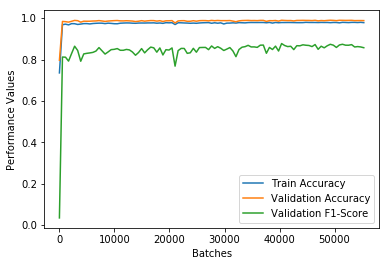

FInal Values: TrAcc: 0.978, ValAcc: 0.988, ValF1: 0.857
Test F1-Score: 0.883



In [8]:
NN = FF_Model(input_size=700, layers=[100])
NN.build_graph()
_,_,_,_ = NN.train(sets, epochs=10, batch=50, show_progress=True, show_plot=True)

In [9]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [10]:
TP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 0)])
TN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 1)])
FP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 1)])
FN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
455	10580	60	61


In [11]:
print(', '.join([sets['test_words'][a] for a in range(len(sets['test_words'])) if res[a] == 0 and tru[a] == 1]))

sliding, magnesium, sublingual, sublingual, sublingual, drug, november, insulin, antibiotics, coumadin, gemfibrozil, lipitor, <num>mg, aspirin, <num>mg, insulin, coverage, drip, regimen, regimen, hypertension;, hypothyroidism;, dyslipidemia;, anticoagulation, meanwhile, monday-wednesday-friday, b.i.d., p.r.n., q.p.m., sliding, flagyl, regimen, monday-wednesday-friday, sliding, intravenous, regimen, milligrams, regimen, q.p.m., q.p.m., #, topical, #, hcl, #, topical, iv, riss, aspirin, sulfa, meds, motrin, aspirin, <num>mg, <num>meq, <num>mg, <num>mg, aspirin, ppi, medications


In [12]:
out = []
for a in range(len(sets['test_words'])):
    if res[a] == 0 and tru[a] == 0:
        out.append(col.Back.GREEN + sets['test_words'][a].upper() + col.Back.RESET)
    elif res[a] == 0 and tru[a] == 1:
        out.append(col.Back.YELLOW + sets['test_words'][a].upper() + col.Back.RESET)
    elif res[a] == 1 and tru[a] == 0:
        out.append(col.Back.RED + sets['test_words'][a].upper() + col.Back.RESET)
    else:
        out.append(sets['test_words'][a])
        
print(' '.join(out))

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mr denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num> she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , howe

In [13]:
pred = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]

In [14]:
sk.metrics.f1_score(tru, pred, pos_label=0, average='binary')

0.33934486566065519

In [16]:
TP, FP, FN = 0, 0, 0
testers = Dataset.get_DS(stage='train', labelled='yes')

for i in range(testers.size):
    current_ds = pool(data=[testers.data[i]])
    #current_ds.show_info()
    current_ds.process_for_testing()
    cur_set, cur_lab, cur_words = current_ds.get_ff_sets(model=model, left_words=3, right_words=3)
    
    cur_res = NN.predict(cur_set)
    cur_tru = np.argmax(cur_lab, 1)
    
    for j in range(len(cur_res)):
        if (cur_words[j] == ')' or cur_words[j] == '('):
            cur_res[j] = 1
            cur_tru[j] = 1
            
    res_words = set()
    tru_words = set()
    res_inside = False
    tru_inside = False
    res_med = ''
    tru_med = ''
    for k in range(len(cur_words)):
        if not res_inside:
            if cur_res[k] == 0:
                res_med = cur_words[k]
                res_inside = True
        else:
            if cur_res[k] == 0:
                res_med = res_med + ' ' + cur_words[k]
            else:
                res_words.add(res_med)
                res_med = 0
                res_inside = False

        if not tru_inside:
            if cur_tru[k] == 0:
                tru_med = cur_words[k]
                tru_inside = True
        else:
            if cur_tru[k] == 0:
                tru_med = tru_med + ' ' + cur_words[k]
            else:
                tru_words.add(tru_med)
                tru_med = 0
                tru_inside = False
    
    #print(', '.join([col.Back.YELLOW + word + col.Back.RESET if word not in tru_words else word for word in res_words]) + '\n')
    #print(', '.join([col.Back.RED + word + col.Back.RESET if word not in res_words else word for word in tru_words]) + '\n')
    
    TP += len([1 for med in res_words if med in tru_words])
    FP += len([1 for med in res_words if med not in tru_words])
    FN += len([1 for med in tru_words if med not in res_words])

print('TP\tFP\tFN\n{}\t{}\t{}'.format(TP, FP, FN))
print('F1-score: {:.4f}'.format((2 * TP) / ( 2 * TP + FP + FN)))

TP	FP	FN
203	56	34
F1-score: 0.8185


In [18]:
TP, FP, FN = 0, 0, 0
testers = Dataset.get_DS(stage='train', labelled='yes')

for i in range(testers.size):
    current_ds = pool(data=[testers.data[i]])
    current_ds.show_info()
    current_ds.process_for_testing()
    cur_set, cur_lab, cur_words = current_ds.get_ff_sets(model=model, left_words=3, right_words=3)
    
    cur_res = NN.predict(cur_set)
    cur_tru = np.argmax(cur_lab, 1)
    
    for j in range(len(cur_res)):
        if (cur_words[j] == ')' or cur_words[j] == '('):
            cur_res[j] = 1
            cur_tru[j] = 1
            
    res_words = set()
    res_inside = False
    res_med = ''
    for k in range(len(cur_words)):
        if not res_inside:
            if cur_res[k] == 0:
                res_med = cur_words[k]
                res_inside = True
        else:
            if cur_res[k] == 0:
                res_med = res_med + ' ' + cur_words[k]
            else:
                res_words.add(res_med)
                res_med = 0
                res_inside = False
    
    tru_words = set()
    for term in re.finditer(r'm="[^"]+"', current_ds.data[0].raw_labels):
        term = term.group()[3:-1]
        term = re.sub(r'\d+', '<num>', term)
        tru_words.add(term)
    
    print(', '.join([col.Back.YELLOW + word + col.Back.RESET if word not in tru_words else word for word in res_words]) + '\n')
    print(', '.join([col.Back.RED + word + col.Back.RESET if word not in res_words else word for word in tru_words]) + '\n')
    
    TP += len([1 for med in res_words if med in tru_words])
    FP += len([1 for med in res_words if med not in tru_words])
    FN += len([1 for med in tru_words if med not in res_words])

print('TP\tFP\tFN\n{}\t{}\t{}'.format(TP, FP, FN))
print('F1-score: {:.4f}'.format((2 * TP) / ( 2 * TP + FP + FN)))

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


isordil, ofloxacin, axid, antibiotics, insulin nph, zestril, insulin lente, colace, heparin, sliding, lopressor, vancomycin, ecotrin, coumadin, percocet

ofloxacin, isordil, axid, insulin nph, antibiotics, zestril, heparin, colace, insulin, insulin lente, urokinase, lopressor, vancomycin, ecotrin, coumadin, percocet

Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


metformin, release, nasal, lantus, aspirin, insulin, magnesium, epinephrine, potassium chloride, humalog insulin, lasix, atenolol, motrin, novolog, toprol-xl, ciprofloxacin, baby aspirin

metformin, potassium chloride slow release, lantus, aspirin, insulin, epinephrine, humalog insulin, nasal cannula, lasix, motrin, atenolol, precedex., novolog, toprol-xl, ciprofloxacin, baby aspirin, beta-blocker

Name:  0105
Challenge:  2009 Medication Challenge

In [22]:
model.most_similar('vancomycin.')

[('*bph*', 0.7897502183914185),
 ('flomax.', 0.7863490581512451),
 ('nubain', 0.7775611281394958),
 ('psych-', 0.7728844285011292),
 ('mauikings', 0.7681817412376404),
 ('meridia', 0.7649649381637573),
 ('micafungin', 0.7636200189590454),
 ('lasix;', 0.7541683912277222),
 ('itching.', 0.7522972822189331),
 ('ocurred', 0.7497338056564331)]

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1